In [1]:
import pandas as pd
import numpy as np

# 可視化用のライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import neologdn
import MeCab

import re

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# # プログレスバーのラベル設定
tqdm_notebook.pandas(desc="progress: ")

#前処理用ライブラリ
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# 機械学習モデル関連ライブラリ
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors


# モデル評価関連ライブラリ
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

from sklearn.decomposition import PCA #主成分分析器

## 品詞で絞った単語を特徴量にしたときのモデル精度を算出

In [2]:
# 内容_id×品詞で絞った単語のデータフレームの読み込み
norm_std001_model_tfidf_df = pd.read_pickle('norm_std001_model_tfidf_df.pkl')
norm_std001_model_tfidf_df.head()

original_type,以上_名詞-非自立-副詞可能,気_名詞-非自立-一般,これ_名詞-代名詞-一般,時間_名詞-副詞可能,おかげ_名詞-一般,何_名詞-代名詞-一般,案件_名詞-一般,こと_名詞-非自立-一般,皆様_名詞-一般,確認_名詞-サ変接続,そう_名詞-接尾-助動詞語幹,よう_名詞-非自立-助動詞語幹,さ_名詞-接尾-特殊,みんな_名詞-代名詞-一般,勉強_名詞-サ変接続,の_名詞-非自立-一般,事_名詞-非自立-一般,業務_名詞-一般
内容_id,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.346674,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.351573,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.254045,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.705146,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [3]:
norm_std001_model_tfidf_df.shape

(50, 18)

## 教師データ紐付け
#### まずは教師データ＆文書歯抜けデータに[内容_id]カラムを付与するために元ファイル(全文書あり)と連結させる

In [4]:
# 教師データ歯抜けファイル（教師データが紐づいていない文書が抜けているデータフレーム）読み込み
df = pd.read_pickle('posi_nega_discretedata.pkl')
df.head()

,text,posi_nega
0,案件個別の技術相談乗ってます！乗ります,1
1,勉強とお仕事が有機的に繋がっていて面白い。,1
2,次々とテクニックを教えていただき、ためになりました,1
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1
4,これが私の最適化,1


In [5]:
# 元ファイル(全文書あり)読み込み
raw_df = pd.read_pickle('posi_nega_alldata.pkl')
raw_df.head()

,text,posi_nega
0,案件個別の技術相談乗ってます！乗ります,1
1,勉強とお仕事が有機的に繋がっていて面白い。,1
2,次々とテクニックを教えていただき、ためになりました,1
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1
4,これが私の最適化,1


In [6]:
# 元ファイルに内容_idカラムを追加する
raw_df['内容_id'] = range(len(raw_df))
# [posi_nega]カラム入らないので除外
raw_df = raw_df[['text', '内容_id']]
raw_df.head()

,text,内容_id
0,案件個別の技術相談乗ってます！乗ります,0
1,勉強とお仕事が有機的に繋がっていて面白い。,1
2,次々とテクニックを教えていただき、ためになりました,2
3,お肉がキレイに焼けたことに小さなしあわせを感じた,3
4,これが私の最適化,4


In [7]:
# 歯抜けファイルと元ファイルを[text]をキーにして紐付け
# 歯抜けファイルをpd.merge関数の第一引数に与える
merge_df = pd.merge(df, raw_df, on='text', how='left')
merge_df.head()

# [内容_id]カラムの紐付け完了

,text,posi_nega,内容_id
0,案件個別の技術相談乗ってます！乗ります,1,0
1,勉強とお仕事が有機的に繋がっていて面白い。,1,1
2,次々とテクニックを教えていただき、ためになりました,1,2
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1,3
4,これが私の最適化,1,4


In [8]:
merge_df.shape

(40, 3)

In [9]:
merge_df.isnull().sum()

text         0
posi_nega    0
内容_id        0
dtype: int64

### ここで教師データを全内容ID×単語のデータフレームと連結させる

In [10]:
# 全内容ID×単語のデータフレームを読み込み
norm_std001_model_tfidf_df = pd.read_pickle('norm_std001_model_tfidf_df.pkl')
norm_std001_model_tfidf_df.head()

original_type,以上_名詞-非自立-副詞可能,気_名詞-非自立-一般,これ_名詞-代名詞-一般,時間_名詞-副詞可能,おかげ_名詞-一般,何_名詞-代名詞-一般,案件_名詞-一般,こと_名詞-非自立-一般,皆様_名詞-一般,確認_名詞-サ変接続,そう_名詞-接尾-助動詞語幹,よう_名詞-非自立-助動詞語幹,さ_名詞-接尾-特殊,みんな_名詞-代名詞-一般,勉強_名詞-サ変接続,の_名詞-非自立-一般,事_名詞-非自立-一般,業務_名詞-一般
内容_id,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.346674,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.351573,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.254045,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.705146,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [11]:
# 内容_idをキーにしてデータフレームを連結
# 教師データがあるデータフレーム(df)をpd.merge関数の第一引数に与える
norm_model_merge_id_df = pd.merge(merge_df, norm_std001_model_tfidf_df, on='内容_id', how='left')
norm_model_merge_id_df.head()

,text,posi_nega,内容_id,以上_名詞-非自立-副詞可能,気_名詞-非自立-一般,これ_名詞-代名詞-一般,時間_名詞-副詞可能,おかげ_名詞-一般,何_名詞-代名詞-一般,案件_名詞-一般,...,皆様_名詞-一般,確認_名詞-サ変接続,そう_名詞-接尾-助動詞語幹,よう_名詞-非自立-助動詞語幹,さ_名詞-接尾-特殊,みんな_名詞-代名詞-一般,勉強_名詞-サ変接続,の_名詞-非自立-一般,事_名詞-非自立-一般,業務_名詞-一般
0,案件個別の技術相談乗ってます！乗ります,1,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.346674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,勉強とお仕事が有機的に繋がっていて面白い。,1,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.351573,0.0,0.0,0.0
2,次々とテクニックを教えていただき、ためになりました,1,2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1,3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,これが私の最適化,1,4,0.0,0.0,0.705146,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [12]:
norm_model_merge_id_df.isnull().any()

text               False
posi_nega          False
内容_id              False
以上_名詞-非自立-副詞可能     False
気_名詞-非自立-一般        False
これ_名詞-代名詞-一般       False
時間_名詞-副詞可能         False
おかげ_名詞-一般          False
何_名詞-代名詞-一般        False
案件_名詞-一般           False
こと_名詞-非自立-一般       False
皆様_名詞-一般           False
確認_名詞-サ変接続         False
そう_名詞-接尾-助動詞語幹     False
よう_名詞-非自立-助動詞語幹    False
さ_名詞-接尾-特殊         False
みんな_名詞-代名詞-一般      False
勉強_名詞-サ変接続         False
の_名詞-非自立-一般        False
事_名詞-非自立-一般        False
業務_名詞-一般           False
dtype: bool

In [13]:
norm_model_merge_id_df.shape

(40, 21)

## 学習データとテストデータに分割

In [14]:
# 順番注意：train_X, test_X, train_y, test_y
# [\](バックスラッシュ)はMacの場合[option(alt)]+[¥]を入力
train_X, test_X, train_y, test_y = \
train_test_split(norm_model_merge_id_df.drop(['text', '内容_id', 'posi_nega'], axis=1),\
                 norm_model_merge_id_df['posi_nega'], test_size=0.2, random_state=0)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(32, 18)
(8, 18)
(32,)
(8,)


## モデル作成
今回はランダムフォレストを使用し、パラメータ調整はしない

In [15]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=30)# 今回はmax_depth=30を除外

## 学習

In [16]:
clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 予測

In [17]:
pred_y = clf.predict(test_X)
pred_y

array([0, 0, 0, 0, 0, 0, 0, 0])

## 正解率・適合率・再現率・F値を算出

In [18]:
# 混同行列を出力

confusion_matrix(test_y, pred_y)
tn, fp, fn, tp = confusion_matrix(test_y, pred_y).ravel()
# (tp, fn, fp, tn)に順番を変更、それを行列にする
print(np.array([[tp, fn], [fp, tn]]))
print('--------------------------------')
# 二次元配列の場合はnumpy.matrix関数でも表現可能
print(np.matrix([[tp, fn], [fp, tn]]))

[[0 3]
 [0 5]]
--------------------------------
[[0 3]
 [0 5]]


In [19]:
# 参考URL：https://pythondatascience.plavox.info/scikit-learn/%E5%88%86%E9%A1%9E%E7%B5%90%E6%9E%9C%E3%81%AE%E3%83%A2%E3%83%87%E3%83%AB%E8%A9%95%E4%BE%A1
# 小数第2位まで出力
print('ポジネガ判定の正解率は%.2fです。' % accuracy_score(test_y, pred_y) )
print('ポジネガ判定の適合率は%.2fです。' % precision_score(test_y, pred_y))
print('ポジネガ判定の再現率は%.2fです。' %recall_score(test_y, pred_y))
print('ポジネガ判定のF値は: %.2fです。' % f1_score(test_y, pred_y))

ポジネガ判定の正解率は0.62です。
ポジネガ判定の適合率は0.00です。
ポジネガ判定の再現率は0.00です。
ポジネガ判定のF値は: 0.00です。


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# 適合率・検出率・F値をまとめて表示するsklearn.metrics.classification_report
# 出力部分の「0」「1」は今回の場合「ネガティブ」「ポジティブ」という意味、「support」は「正解ラベルのデータの数」を意味する
print(classification_report(test_y, pred_y))

             precision    recall  f1-score   support

          0       0.62      1.00      0.77         5
          1       0.00      0.00      0.00         3

avg / total       0.39      0.62      0.48         8



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## ランダムフォレストで使用した特徴量と重要度を格納したデータフレームを作成

In [21]:
# 各単語とその重要度をカラムにしたデータフレームを作成
feature_importances_dict = {'word':train_X.columns,
                         'feature_importances_':clf.feature_importances_
                        }

feature_importances_df = pd.DataFrame(feature_importances_dict)
feature_importances_df = feature_importances_df.sort_values('feature_importances_', ascending=False)#重要度を降順にする
feature_importances_df#完成

,word,feature_importances_
7,こと_名詞-非自立-一般,0.161130
10,そう_名詞-接尾-助動詞語幹,0.086164
15,の_名詞-非自立-一般,0.075872
6,案件_名詞-一般,0.075437
8,皆様_名詞-一般,0.073142
3,時間_名詞-副詞可能,0.062666
16,事_名詞-非自立-一般,0.060057
0,以上_名詞-非自立-副詞可能,0.054540
14,勉強_名詞-サ変接続,0.053352
1,気_名詞-非自立-一般,0.051221


## ランダムフォレストで使用した特徴量の重要度を可視化

In [22]:
# 重要度可視化準備
# 横棒グラフにするために重要度を昇順にする
asc_feature_importances_df = feature_importances_df.sort_values('feature_importances_', ascending=True)
asc_feature_importances_df.head()

,word,feature_importances_
9,確認_名詞-サ変接続,0.005059
5,何_名詞-代名詞-一般,0.016540
2,これ_名詞-代名詞-一般,0.016613
12,さ_名詞-接尾-特殊,0.023363
4,おかげ_名詞-一般,0.039388


In [23]:
# set_index()関数でデータフレームの既存の列をindex（行名、行ラベル）に割り当て
asc_feature_importances_df = asc_feature_importances_df.set_index('word')

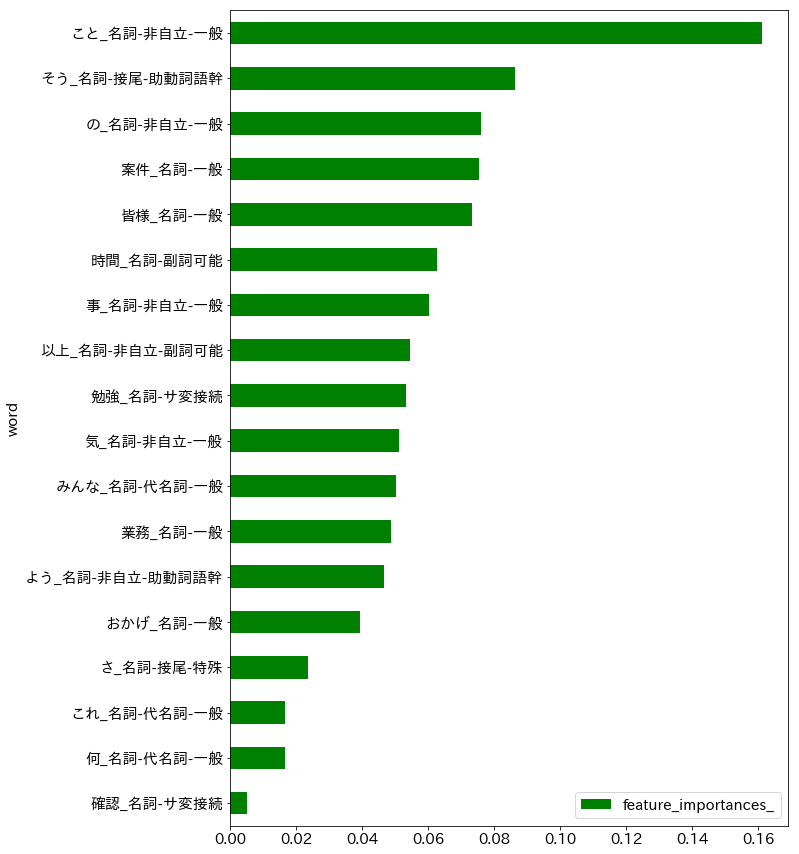

In [24]:
# 横棒グラフ作成
plt.rcParams["font.size"] = 15
asc_feature_importances_df.plot.barh(figsize=(10,15),align='center', color='green')

## 予測データを正解データと紐付け、予測が外れた文書の内容を確認できるデータフレームを作成

In [25]:
# 確認&考察
test_X
# 残念ながらindex番号=内容_idではない
# よって教師データ、予測データを連結される際にはindex番号をキーにして連結させるjoin関数を使用することにする

,以上_名詞-非自立-副詞可能,気_名詞-非自立-一般,これ_名詞-代名詞-一般,時間_名詞-副詞可能,おかげ_名詞-一般,何_名詞-代名詞-一般,案件_名詞-一般,こと_名詞-非自立-一般,皆様_名詞-一般,確認_名詞-サ変接続,そう_名詞-接尾-助動詞語幹,よう_名詞-非自立-助動詞語幹,さ_名詞-接尾-特殊,みんな_名詞-代名詞-一般,勉強_名詞-サ変接続,の_名詞-非自立-一般,事_名詞-非自立-一般,業務_名詞-一般
22,0.000000,0.136193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117949,0.0,0.0,0.0,0.0,0.0,0.0
20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.705146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
10,1.054719,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
28,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
test_X.shape

(8, 18)

In [27]:
# まずは、test_Xに教師データの紐付けから行う
# [内容ID]×[単語＋教師データ]のデータフレームを紐付ける
supervised_df = norm_model_merge_id_df[['text', 'posi_nega']]
test_X_supervised_join_df = test_X.join(supervised_df, how='left')
test_X_supervised_join_df

,以上_名詞-非自立-副詞可能,気_名詞-非自立-一般,これ_名詞-代名詞-一般,時間_名詞-副詞可能,おかげ_名詞-一般,何_名詞-代名詞-一般,案件_名詞-一般,こと_名詞-非自立-一般,皆様_名詞-一般,確認_名詞-サ変接続,そう_名詞-接尾-助動詞語幹,よう_名詞-非自立-助動詞語幹,さ_名詞-接尾-特殊,みんな_名詞-代名詞-一般,勉強_名詞-サ変接続,の_名詞-非自立-一般,事_名詞-非自立-一般,業務_名詞-一般,text,posi_nega
22,0.000000,0.136193,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117949,0.0,0.0,0.0,0.0,0.0,0.0,変化があると言われていた気がするけど、変わっているように見えない。期待して損した,0
20,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,行くっていったけど家を出たくない,0
25,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,良い子はこういう大人になっていはいけない。,0
4,0.000000,0.000000,0.705146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,これが私の最適化,1
10,1.054719,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,10歳以上若い判定,1
15,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,正直精度自体はよくなかった,0
28,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,夕方ごろに検証用コードにミスを見つけてしまう。,0
11,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2週連続での出展お疲れ様でした,1


In [28]:
test_X_supervised_join_df.shape

(8, 20)

In [29]:
# 次に単語カラムを除外し、予測した結果を格納したカラムを新規で作成する
test_X_supervised_pred_join_df = test_X_supervised_join_df[['text', 'posi_nega']]# 単語カラムを除外
test_X_supervised_pred_join_df['pred'] = pred_y# 新規カラムに予測した結果を格納
test_X_supervised_pred_join_df

# 完成

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,posi_nega,pred
22,変化があると言われていた気がするけど、変わっているように見えない。期待して損した,0,0
20,行くっていったけど家を出たくない,0,0
25,良い子はこういう大人になっていはいけない。,0,0
4,これが私の最適化,1,0
10,10歳以上若い判定,1,0
15,正直精度自体はよくなかった,0,0
28,夕方ごろに検証用コードにミスを見つけてしまう。,0,0
11,2週連続での出展お疲れ様でした,1,0
